In [154]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC

vectorizer = SentenceTransformer('intfloat/multilingual-e5-large-instruct', cache_folder="N:\AI\Transformers_cache")
#vectorizer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#vectorizer = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
#vectorizer = SentenceTransformer('avsolatorio/GIST-large-Embedding-v0', device='cuda:0')
#model = MLPClassifier(random_state=42, alpha=0.25)
model = LinearSVC(C=0.5, random_state=42)

data = pd.read_csv('Annotated_data.csv')
distortion_data = data[data['Dominant Distortion'] != 'No Distortion']
distortion_data = distortion_data.reset_index(drop=True)

discreteData = data[['Id_Number', 'Patient Question', 'Dominant Distortion']].copy()
discreteData.loc[discreteData['Dominant Distortion'] != 'No Distortion', 'Dominant Distortion'] = 'Distorted'

# undersample the majority class of the discrete data to be equal to the minority class
no_distortion = discreteData[discreteData['Dominant Distortion'] == 'No Distortion']
distorted = discreteData[discreteData['Dominant Distortion'] == 'Distorted']
distorted = distorted.sample(n=no_distortion.shape[0], random_state=42)
#discreteData = pd.concat([no_distortion, distorted])
#discreteData = discreteData.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(discreteData['Patient Question'], discreteData['Dominant Distortion'], test_size=0.2, random_state=42)

# print the classes in discreteData
print(discreteData['Dominant Distortion'].value_counts())

Distorted        1597
No Distortion     933
Name: Dominant Distortion, dtype: int64


In [155]:
# load the generated data from "distorted_parts5sample150.csv" to add to the training data
generated_data = pd.read_csv('distorted_parts2.csv')
generated_data = generated_data.dropna()
generated_data = generated_data.reset_index(drop=True)

# Change the "Mental Filers" class name to "Mental filter" to match the original data
generated_data['Dominant Distortion'] = generated_data['Dominant Distortion'].replace('Mental Filter', 'Mental filter')

# remove the generated data which contains "[INST]" and "<|im_start|>", and do some other preprocessing
generated_data = generated_data[~generated_data['Distorted part'].str.contains("\[INST\]|\|im_start\|")]

# remove "\n" characters from the generated data
generated_data['Distorted part'] = generated_data['Distorted part'].str.replace("\n", " ")

# print the generated data's unique classes
print(generated_data['Dominant Distortion'].unique())

# print the original data's unique classes
print(distortion_data['Dominant Distortion'].unique())

# print the amount of data per class
generated_data['Dominant Distortion'].value_counts()

['Magnification' 'Labeling' 'Personalization' 'Fortune-telling'
 'Emotional Reasoning' 'Mental filter']
['Personalization' 'Labeling' 'Fortune-telling' 'Magnification'
 'Mind Reading' 'All-or-nothing thinking' 'Overgeneralization'
 'Mental filter' 'Emotional Reasoning' 'Should statements']


Mental filter          116
Emotional Reasoning    105
Fortune-telling         96
Personalization         86
Labeling                74
Magnification           41
Name: Dominant Distortion, dtype: int64

In [156]:
# Clean the data
discreteData['Patient Question'] = discreteData['Patient Question'].str.replace(r'[^\w\s]', '')
discreteData['Patient Question'] = discreteData['Patient Question'].str.replace(r'\d+', '')
discreteData['Patient Question'] = discreteData['Patient Question'].str.lower()

# Clean the generated data
generated_data['Distorted part'] = generated_data['Distorted part'].str.replace(r'[^\w\s]', '')
generated_data['Distorted part'] = generated_data['Distorted part'].str.replace(r'\d+', '')
generated_data['Distorted part'] = generated_data['Distorted part'].str.lower()

C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1614901727.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  discreteData['Patient Question'] = discreteData['Patient Question'].str.replace(r'[^\w\s]', '')
C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1614901727.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  discreteData['Patient Question'] = discreteData['Patient Question'].str.replace(r'\d+', '')
C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1614901727.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  generated_data['Distorted part'] = generated_data['Distorted part'].str.replace(r'[^\w\s]', '')
C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1614901727.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  generated_data['Distorted part'] = generated_data['Distorted par

In [157]:
# make the generated data's class names be discrete
generated_data.loc[generated_data['Dominant Distortion'] != 'No Distortion', 'Dominant Distortion'] = 'Distorted'

# print the amount of data per class
print(generated_data['Dominant Distortion'].value_counts())

# add the generated data to the training data
X_train_new = X_train.append(generated_data['Distorted part'], ignore_index=True)
y_train_new = y_train.append(generated_data['Dominant Distortion'], ignore_index=True)

# add the generated data to the distortion data
discreteData_new = discreteData.append(generated_data, ignore_index=True)

# print the amount of data per class
discreteData_new['Dominant Distortion'].value_counts()

Distorted    518
Name: Dominant Distortion, dtype: int64


C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1168663754.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_new = X_train.append(generated_data['Distorted part'], ignore_index=True)
C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1168663754.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_new = y_train.append(generated_data['Dominant Distortion'], ignore_index=True)
C:\Users\meaps\AppData\Local\Temp\ipykernel_25592\1168663754.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  discreteData_new = discreteData.append(generated_data, ignore_index=True)


Distorted        2115
No Distortion     933
Name: Dominant Distortion, dtype: int64

In [158]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV

def tuneParams(model, params, X_train, y_train, X_test, y_test):
    # Create a HalvingGridSearchCV and a RandomizedSearchCV object with the model and vectorizer
    search = HalvingGridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
    #search = RandomizedSearchCV(model, params, n_iter=100, cv=5, n_jobs=-1, verbose=1)

    # Train and test the model
    search.fit(X_train, y_train)

    # Predict the labels for the testing data
    y_pred = search.predict(X_test)

    # Calculate the F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Output the F1-score
    print(f"{model.__class__.__name__} F1-score: {f1}")

    # Print the best parameters
    print(search.best_params_)
    return (f1, search)

In [159]:
# vectorize the data
X_train_vectorized_new = vectorizer.encode(X_train_new.tolist())
print("Finished Encoding X Training Data")
X_test_vectorized = vectorizer.encode(X_test.tolist())
print("Finished Encoding X Testing Data")

Finished Encoding X Training Data
Finished Encoding X Testing Data


In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an array of models to test
models = [
#    BernoulliNB(),
    LogisticRegression(),
#    SGDClassifier(),
    SVC(),
    LinearSVC(),
#    DecisionTreeClassifier(),
#    RandomForestClassifier(),
#    AdaBoostClassifier(),
#    KNeighborsClassifier(),
    MLPClassifier(),
#    NuSVC()
]

# Create an array of model parameters to test
params = [
#    {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    {'C': [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
#    {'alpha': [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]},
    {'C': [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10]},
    {'C': [0.35, 0.4, 0.5, 0.6, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]},
#    {'max_depth': [1, 2, 3, 4, 5 ]},
#    {'n_estimators': [70, 80, 90, 100, 110, 120, 130, 140]},
#    {'n_estimators': [35, 40, 45, 50, 55, 60, 65, 70, 75]},
#    {'n_neighbors': [10, 11, 12, 13, 14, 16, 18, 20, 22]},
    {'alpha': [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]},
#    {'nu': [0.6, 0.65, 0.7]}
]

# store the F1-scores
f1_scores = []

best_model = None
temp_model = None

# test all models
for i in range(len(models)):
    f1, temp_model = tuneParams(models[i], params[i], X_train_vectorized_new, y_train_new, X_test_vectorized, y_test)
    
    if best_model == None or f1 > max(f1_scores):
        best_model = temp_model

    f1_scores.append(f1)



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 94
max_resources_: 2542
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 45
n_resources: 94
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 15
n_resources: 282
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 5
n_resources: 846
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 2538
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression F1-score: 0.7563810963559895
{'C': 8.5}
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 94
max_resources_: 2542
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 94
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 282
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 846
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 2538
Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVC F1-score: 0.7591338265531513
{'C': 2.75}
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 94
max_resources_: 2542
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 94
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n

c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC F1-score: 0.751978145082053
{'C': 0.5}
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 282
max_resources_: 2542
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 14
n_resources: 282
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 1
n_candidates: 5
n_resources: 846
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 2538
Fitting 5 folds for each of 2 candidates, totalling 10 fits
MLPClassifier F1-score: 0.7502491893881852
{'alpha': 0.4}


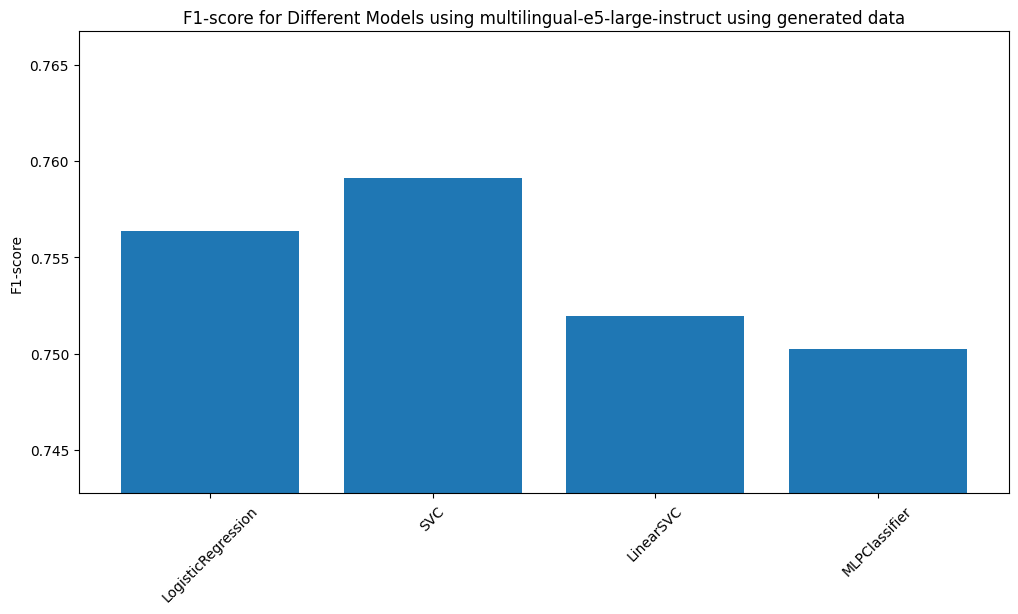

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# graph the F1-scores
plt.figure(figsize=(12, 6))
plt.bar([model.__class__.__name__ for model in models], f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1-score')
plt.ylim(min(f1_scores)*0.99, max(f1_scores)*1.01)
plt.title(f'F1-score for Different Models using {"multilingual-e5-large-instruct"} using generated data')
plt.show()

Distorted        2115
No Distortion     933
Name: Dominant Distortion, dtype: int64


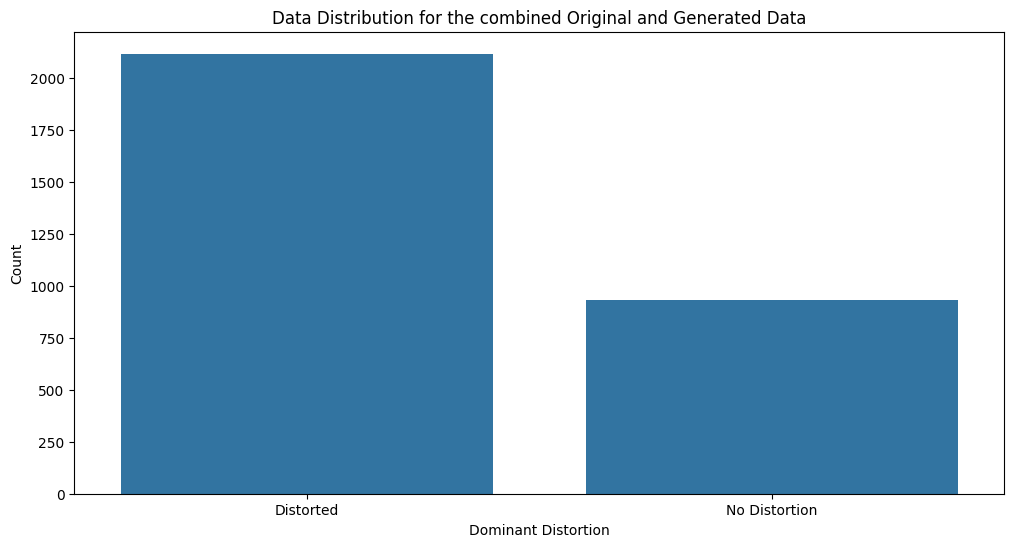

In [162]:
# print the data distribution
print(discreteData_new['Dominant Distortion'].value_counts())
# graph the data distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=discreteData_new, x='Dominant Distortion')
plt.ylabel('Count')
plt.title('Data Distribution for the combined Original and Generated Data')
plt.show()

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 94
max_resources_: 2542
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 35
n_resources: 94
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 1
n_candidates: 12
n_resources: 282
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 846
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 2538
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'C': 4.75} F1-score: 0.7474797303109096
HalvingGridSearchCV F1-score: 0.7474797303109096
               precision    recall  f1-score   support

    Distorted       0.79      0.85      0.82       331
No Distortion       0.67      0.57      0.61       175

     accuracy                           0.75       506
    macro avg       0.73      0.71      0.72       506
 weighted avg       0.75      0.75

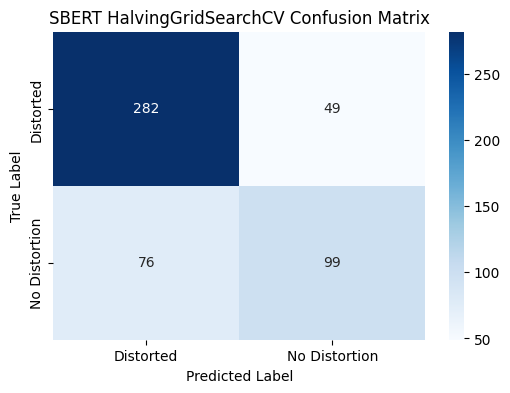

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
'''
# run the best model with the best parameters
for i in range(len(models)):
    if f1_scores[i] == max(f1_scores):
        best_model = models[i]
        best_params = params[i]
        break

# train the best model with the best parameters manually
search = HalvingGridSearchCV(best_model, best_params, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train_vectorized_new, y_train_new)
y_pred = search.predict(X_test_vectorized)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"{best_model.__class__.__name__} F1-score: {f1}")
'''

# train the best model with the best parameters manually
best_model.fit(X_train_vectorized_new, y_train_new)
y_pred = best_model.predict(X_test_vectorized)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"{best_model.best_params_} F1-score: {f1}")
print(f"{best_model.__class__.__name__} F1-score: {f1}")

# print the full f1 score statistics
print(classification_report(y_test, y_pred, target_names=discreteData_new['Dominant Distortion'].unique()))

# print the confusion matrix with the actual and predicted labels
print(confusion_matrix(y_test, y_pred, labels=discreteData_new['Dominant Distortion'].unique()))

# plot the confusion matrix as a heatmap
labels = discreteData_new['Dominant Distortion'].unique()
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'SBERT {best_model.__class__.__name__} Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [164]:
# print the best parameters
print(best_model.best_params_)

{'C': 4.75}
